In [57]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from noise_position import Position
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import time
import torch.optim as optim

# Loading Data

The output of torchvision datasets are PILImage images of range [0, 1].

We transform them to Tensors of normalized range [-1, 1].

In [58]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = Position('./cifar_data', train=True,
                                        download=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = Position('./cifar_data', train=False,
                                        download=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

print(len(trainset))
print(len(testset))

65856
16464


Here we ensure that there is no correlation between numbers and objects in our dataset.

In [3]:
b = [[[[0 for _ in range(3)] for _ in range(30)] for _ in range(30)] for _ in range(10)]

b = np.array([np.array([np.array([np.array([0 for _ in range(28)]) for _ in range(28)]) for _ in range(10)]) for _ in range(3)])

for i in range(len(trainset)):
    label = trainset[i][1]
    b[label[0]][label[3]][label[1]][label[2]] += 1

In [4]:
print(b[0][0])

[[2 1 3 1 1 2 2 1 1 3 4 4 4 2 4 2 3 5 3 1 5 1 3 2 3 3 2 1]
 [3 7 3 4 3 5 4 1 2 2 2 2 3 4 3 3 4 3 2 4 2 4 3 1 3 2 5 3]
 [3 2 3 0 2 2 4 3 1 2 5 3 3 3 2 4 1 1 3 1 6 1 4 3 2 2 4 3]
 [3 3 1 1 2 3 2 2 3 1 3 4 3 4 1 2 5 4 3 2 4 4 5 1 2 3 2 4]
 [2 4 4 3 3 5 1 2 7 2 3 6 2 7 4 3 1 6 5 4 1 5 4 4 1 5 1 3]
 [2 2 4 5 3 2 1 2 1 3 3 1 6 2 5 8 3 3 3 3 3 3 6 1 1 0 2 4]
 [2 4 4 3 5 1 3 1 4 1 4 2 2 4 4 2 1 4 3 3 1 1 3 2 2 3 3 3]
 [0 2 2 3 5 6 4 2 2 3 2 3 4 2 5 3 1 1 3 6 4 2 4 3 2 3 2 0]
 [3 1 6 1 4 4 3 3 4 5 7 1 6 5 3 5 3 3 3 3 4 3 3 2 2 2 3 6]
 [2 2 3 3 4 2 2 2 3 2 1 1 4 3 0 1 3 2 2 2 3 1 2 2 2 3 0 0]
 [0 1 2 3 3 2 6 2 4 4 1 3 4 2 1 1 6 2 5 0 2 3 5 9 1 4 2 2]
 [0 3 3 1 2 3 2 4 4 1 4 4 5 1 2 2 5 4 3 4 2 1 2 4 0 4 6 2]
 [3 5 6 3 2 2 2 3 3 2 1 2 1 1 4 2 3 5 3 2 4 3 4 5 3 1 2 1]
 [0 1 3 3 2 3 2 1 4 4 4 4 0 3 2 7 1 2 2 2 2 1 2 2 4 1 2 5]
 [0 3 3 2 6 2 4 1 3 2 5 3 2 4 3 3 0 0 2 2 3 2 1 2 3 4 1 4]
 [0 3 5 1 6 1 1 4 3 7 3 4 5 3 7 2 4 2 2 1 0 1 4 4 2 4 5 5]
 [1 4 0 4 5 1 2 0 1 4 0 2 2 0 5 1 3 2 5 4 2 1 2 2 1 4 4 

In [59]:
color_classes = ["red", "green", "blue"]
x_axis_classes = [i for i in range(2, 30)]
y_axis_classes = [i for i in range(2, 30)]
cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def color_task(l):
    return l[0]

def x_axis_task(l):
    return l[1]

def x_axis_denorm(l):
    return float(l * 13.5 + 2 + 13.5)

def y_axis_task(l):
    return l[2]

def y_axis_denorm(l):
    return float(l * 13.5 + 2 + 13.5)

def cifar_task(l):
    return l[3]
        
label_to_task0 = color_task
task0_classes = color_classes

label_to_task1 = x_axis_task
task1_to_label = x_axis_denorm
task1_classes = x_axis_classes

label_to_task2 = y_axis_task
task2_to_label = y_axis_denorm
task2_classes = y_axis_classes

label_to_task3 = cifar_task
task3_classes = cifar_classes

## Training Data Samples

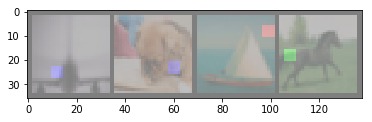

 blue  blue   red green
   10    24    29     4
   23    21     6    16
plane   dog  ship horse


In [62]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % task0_classes[label_to_task0(labels[j])] for j in range(4)))
#print(' '.join('%5s' % task1_to_label(label_to_task1(labels[j])) for j in range(4)))
#print(' '.join('%5s' % task2_to_label(label_to_task2(labels[j])) for j in range(4)))
print(' '.join('%5s' % task1_classes[label_to_task1(labels[j])] for j in range(4)))
print(' '.join('%5s' % task2_classes[label_to_task2(labels[j])] for j in range(4)))
print(' '.join('%5s' % task3_classes[label_to_task3(labels[j])] for j in range(4)))


# Defining the Model

In [60]:
class Net(nn.Module):

    #nettype looks like [0->4, 0->4, 0->4]
    def __init__(self, netType, size="large"):
        super(Net, self).__init__()
        self.netType = netType
        
        if size == "large":
            self.half = 64
        elif size == "small":
            self.half = 16
        else:
            raise Exception("Wrong Size")
        #large
        self.conv1_1 = nn.Conv2d(3, self.half, 3)
        self.conv1_2 = nn.Conv2d(3, self.half, 3)
        self.conv1_3 = nn.Conv2d(3, self.half, 3)
        self.conv1_4 = nn.Conv2d(3, self.half, 3)

        self.conv2_1 = nn.Conv2d(self.half, self.half, 3)
        self.conv2_2 = nn.Conv2d(self.half, self.half, 3)
        self.conv2_3 = nn.Conv2d(self.half, self.half, 3)
        self.conv2_4 = nn.Conv2d(self.half, self.half, 3)

        self.conv3_1 = nn.Conv2d(self.half, self.half*2, 3)
        self.conv3_2 = nn.Conv2d(self.half, self.half*2, 3)
        self.conv3_3 = nn.Conv2d(self.half, self.half*2, 3)
        self.conv3_4 = nn.Conv2d(self.half, self.half*2, 3)

        self.conv4_1 = nn.Conv2d(self.half*2, self.half*2, 3)
        self.conv4_2 = nn.Conv2d(self.half*2, self.half*2, 3)
        self.conv4_3 = nn.Conv2d(self.half*2, self.half*2, 3)
        self.conv4_4 = nn.Conv2d(self.half*2, self.half*2, 3)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1_0 = nn.Linear(self.half*2 * 5 * 5, 16)
        self.fc2_0 = nn.Linear(16, len(task0_classes))

        self.fc1_1 = nn.Linear(self.half*2 * 5 * 5, 16)
        self.fc2_1 = nn.Linear(16, len(task1_classes))

        self.fc1_2 = nn.Linear(self.half*2 * 5 * 5, 16)
        self.fc2_2 = nn.Linear(16, len(task2_classes))

        self.fc1_3 = nn.Linear(self.half*2 * 5 * 5, 16)
        self.fc2_3 = nn.Linear(16, len(task3_classes))
        
        self.softmax = nn.LogSoftmax(dim=1) #LogSoftmax or Softmax?

    def forward(self, x):
        l0 = x
        l1 = F.relu(self.conv1_1(x))
        l2 = self.pool(F.relu(self.conv2_1(l1)))
        l3 = F.relu(self.conv3_1(l2))
        l4 = self.pool(F.relu(self.conv4_1(l3)))

        if self.netType[0] == 0:
            l1_2 = F.relu(self.conv1_2(l0))
            l2_2 = self.pool(F.relu(self.conv2_2(l1_2)))
            l3_2 = F.relu(self.conv3_2(l2_2))
            l4_2 = self.pool(F.relu(self.conv4_2(l3_2)))
        elif self.netType[0] == 1:
            l2_2 = self.pool(F.relu(self.conv2_2(l1)))
            l3_2 = F.relu(self.conv3_2(l2_2))
            l4_2 = self.pool(F.relu(self.conv4_2(l3_2)))
        elif self.netType[0] == 2:
            l3_2 = F.relu(self.conv3_2(l2))
            l4_2 = self.pool(F.relu(self.conv4_2(l3_2)))
        elif self.netType[0] == 3:
            l4_2 = self.pool(F.relu(self.conv4_2(l3)))

        if self.netType[1] == 0:
            l1_3 = F.relu(self.conv1_3(l0))
            l2_3 = self.pool(F.relu(self.conv2_3(l1_3)))
            l3_3 = F.relu(self.conv3_3(l2_3))
            l4_3 = self.pool(F.relu(self.conv4_3(l3_3)))
        elif self.netType[1] == 1:
            l2_3 = self.pool(F.relu(self.conv2_3(l1)))
            l3_3 = F.relu(self.conv3_3(l2_3))
            l4_3 = self.pool(F.relu(self.conv4_3(l3_3)))
        elif self.netType[1] == 2:
            l3_3 = F.relu(self.conv3_3(l2))
            l4_3 = self.pool(F.relu(self.conv4_3(l3_3)))
        elif self.netType[1] == 3:
            l4_3 = self.pool(F.relu(self.conv4_3(l3)))

        if self.netType[2] == 0:
            l1_4 = F.relu(self.conv1_4(l0))
            l2_4 = self.pool(F.relu(self.conv2_4(l1_4)))
            l3_4 = F.relu(self.conv3_4(l2_4))
            l4_4 = self.pool(F.relu(self.conv4_4(l3_4)))
        elif self.netType[2] == 1:
            l2_4 = self.pool(F.relu(self.conv2_4(l1)))
            l3_4 = F.relu(self.conv3_4(l2_4))
            l4_4 = self.pool(F.relu(self.conv4_4(l3_4)))
        elif self.netType[2] == 2:
            l3_4 = F.relu(self.conv3_4(l2))
            l4_4 = self.pool(F.relu(self.conv4_4(l3_4)))
        elif self.netType[2] == 3:
            l4_4 = self.pool(F.relu(self.conv4_4(l3)))

        x1 = l4.view(-1, self.half*2 * 5 * 5)
        x1 = self.fc2_0(F.relu(self.fc1_0(x1)))

        if self.netType[0] == 4:
            x2 = l4.view(-1, self.half*2 * 5 * 5)
            x2 = self.fc2_1(F.relu(self.fc1_1(x2)))
        else:
            x2 = l4_2.view(-1, self.half*2 * 5 * 5)
            x2 = self.fc2_1(F.relu(self.fc1_1(x2)))

        if self.netType[1] == 4:
            x3 = l4.view(-1, self.half*2 * 5 * 5)
            x3 = self.fc2_2(F.relu(self.fc1_2(x3)))
        else:
            x3 = l4_3.view(-1, self.half*2 * 5 * 5)
            x3 = self.fc2_2(F.relu(self.fc1_2(x3)))

        if self.netType[2] == 4:
            x4 = l4.view(-1, self.half*2 * 5 * 5)
            x4 = self.fc2_3(F.relu(self.fc1_3(x4)))
        else:
            x4 = l4_4.view(-1, self.half*2 * 5 * 5)
            x4 = self.fc2_3(F.relu(self.fc1_3(x4)))

        return self.softmax(x1), self.softmax(x2), self.softmax(x3), self.softmax(x4)

Ensure that the network is as expected by visualization

In [70]:
net = Net([0, 0, 0])
torch.onnx.export(net, dataiter.next()[0], "./net000.onnx", verbose=True, export_params=True)

graph(%0 : Float(4, 3, 32, 32)
      %1 : Float(64, 3, 3, 3)
      %2 : Float(64)
      %3 : Float(64, 3, 3, 3)
      %4 : Float(64)
      %5 : Float(64, 3, 3, 3)
      %6 : Float(64)
      %7 : Float(64, 3, 3, 3)
      %8 : Float(64)
      %9 : Float(64, 64, 3, 3)
      %10 : Float(64)
      %11 : Float(64, 64, 3, 3)
      %12 : Float(64)
      %13 : Float(64, 64, 3, 3)
      %14 : Float(64)
      %15 : Float(64, 64, 3, 3)
      %16 : Float(64)
      %17 : Float(128, 64, 3, 3)
      %18 : Float(128)
      %19 : Float(128, 64, 3, 3)
      %20 : Float(128)
      %21 : Float(128, 64, 3, 3)
      %22 : Float(128)
      %23 : Float(128, 64, 3, 3)
      %24 : Float(128)
      %25 : Float(128, 128, 3, 3)
      %26 : Float(128)
      %27 : Float(128, 128, 3, 3)
      %28 : Float(128)
      %29 : Float(128, 128, 3, 3)
      %30 : Float(128)
      %31 : Float(128, 128, 3, 3)
      %32 : Float(128)
      %33 : Float(16, 3200)
      %34 : Float(16)
      %35 : Float(3, 16)
      %36 : Float(3)
  

## Defining the Loss function and Optimizer

In [55]:
classifier_criterion = nn.CrossEntropyLoss()
regression_criterion = nn.MSELoss()
#optimizer = optim.Adam(net.parameters())
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# Training the Network

In [168]:
def train(net, optimizer, c_crit, r_crit, log=None, cud=None, epochs=1):
    print("Starting Training")
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss_total = 0.0
        running_loss_1 = 0.0
        running_loss_2 = 0.0
        running_loss_3 = 0.0
        running_loss_4 = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            if cud != None:
                inputs = inputs.cuda(cud, async=True)
                labels = labels.cuda(cud, async=True)
                
            labels1 = torch.tensor([label_to_task0(l) for l in labels])
            labels2 = torch.tensor([label_to_task1(l) for l in labels])
            labels3 = torch.tensor([label_to_task2(l) for l in labels])
            labels4 = torch.tensor([label_to_task3(l) for l in labels])

            if cud != None:
                labels1.cuda(cud, async=True)
                labels2.cuda(cud, async=True)
                labels3.cuda(cud, async=True)
                labels4.cuda(cud, async=True)
                
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs1, outputs2, outputs3, outputs4 = net(inputs)
            loss1 = c_crit(outputs1, labels1)
            loss2 = c_crit(outputs2, labels2)
            loss3 = c_crit(outputs3, labels3)
            loss4 = c_crit(outputs4, labels4)
            #loss = (loss2 + loss3) / 2
            loss = (loss1 + loss2/2 + loss3/2 + loss4) / 4
            loss.backward()
            optimizer.step()

            # print statistics
            with torch.no_grad():
                running_loss_total += loss.item()
                running_loss_1 += loss1.item()
                running_loss_2 += loss2.item()
                running_loss_3 += loss3.item()
                running_loss_4 += loss4.item()
                if i % 7000 == 6999:    # print every 2000 mini-batches
                    if log != None:
                        log["total"].append(running_loss_total / 7000)
                        log["task_0"].append(running_loss_1 / 7000)
                        log["task_1"].append(running_loss_2 / 7000)
                        log["task_2"].append(running_loss_3 / 7000)
                        log["task_3"].append(running_loss_4 / 7000)
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss_total / 7000))
                    running_loss_total = 0.0
                    running_loss1 = 0.0
                    running_loss2 = 0.0
                    running_loss3 = 0.0
                    running_loss4 = 0.0

    print('Finished Training')

In [170]:
for _ in range(1):
    train(net, optimizer, classifier_criterion, regression_criterion)

Starting Training


KeyboardInterrupt: 

# Testing the Network

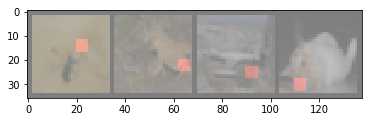

GroundTruth:    red   red   red   red
GroundTruth:     20    28    22     8
GroundTruth:     12    20    23    28
GroundTruth:    cat  frog plane   cat


In [171]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % task0_classes[label_to_task0(labels[j])] for j in range(4)))
print('GroundTruth: ', ' '.join('%5s' % task1_classes[label_to_task1(labels[j])] for j in range(4)))
print('GroundTruth: ', ' '.join('%5s' % task2_classes[label_to_task2(labels[j])] for j in range(4)))
print('GroundTruth: ', ' '.join('%5s' % task3_classes[label_to_task3(labels[j])] for j in range(4)))


In [172]:
outputs1, outputs2, outputs3, outputs4 = net(images)

_, predicted = torch.max(outputs1, 1)
print('Predicted: ', ' '.join('%5s' % task0_classes[predicted[j]]
                              for j in range(4)))
_, predicted = torch.max(outputs2, 1)
print('Predicted: ', ' '.join('%5s' % task1_classes[predicted[j]]
                              for j in range(4)))
_, predicted = torch.max(outputs3, 1)
print('Predicted: ', ' '.join('%5s' % task2_classes[predicted[j]]
                              for j in range(4)))
_, predicted = torch.max(outputs4, 1)
print('Predicted: ', ' '.join('%5s' % task3_classes[predicted[j]]
                              for j in range(4)))

Predicted:    red   red   red   red
Predicted:     19    19    19    19
Predicted:     11    17    23    19
Predicted:   bird  deer truck   dog


In [173]:
def test_overall(net, performance=None):
    correct0 = 0
    total0 = 0
    correct1 = 0
    total1 = 0
    correct2 = 0
    total2 = 0
    correct3 = 0
    total3 = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            labels0 = torch.tensor([label_to_task0(l) for l in labels])
            labels1 = torch.tensor([label_to_task1(l) for l in labels])
            labels2 = torch.tensor([label_to_task2(l) for l in labels])
            labels3 = torch.tensor([label_to_task3(l) for l in labels])
            outputs0, outputs1, outputs2, outputs3 = net(images)
            _, predicted0 = torch.max(outputs0.data, 1)
            _, predicted1 = torch.max(outputs1.data, 1)
            _, predicted2 = torch.max(outputs2.data, 1)
            _, predicted3 = torch.max(outputs3.data, 1)
            total0 += labels0.size(0)
            total1 += labels1.size(0)
            total2 += labels2.size(0)
            total3 += labels3.size(0)
            
            correct0 += (predicted0 == labels0).sum().item()
            correct1 += (predicted1 == labels1).sum().item()
            correct2 += (predicted2 == labels2).sum().item()
            correct3 += (predicted3 == labels3).sum().item()
            

    print('task_0 accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct0 / total0))
    print('task_1 accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct1 / total1))
    print('task_2 accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct2 / total2))
    print('task_3 accuracy of the network on the 10000 test images: %d %%' % (100 * correct3 / total3))
    
    if performance != None:
        performance["task_0"].append(100 * correct0 / total0)
        performance["task_1"].append(100 * correct1 / total1)
        performance["task_2"].append(100 * correct2 / total2)
        performance["task_3"].append(100 * correct3 / total3)

In [174]:
test_overall(net)

task_0 accuracy of the network on the 10000 test images: 33 %
task_1 accuracy of the network on the 10000 test images: 4 %
task_2 accuracy of the network on the 10000 test images: 5 %
task_3 accuracy of the network on the 10000 test images: 50 %


# Automate Testing Process

In [154]:
def get_performance_data(net, c_crit, r_crit, optimizer, epochs=1, cud=None):
    performance = {'task_0':[], 'task_1':[], 'task_2':[], 'task_3':[]}
    log = {'total':[], 'task_0':[], 'task_1':[], 'task_2':[], 'task_3':[]}

    for e in range(epochs):
        train(net, optimizer, c_crit, r_crit, log=log, epochs=1, cud=cud)
        test_overall(net, performance)

    return performance, log

In [165]:
def train_job(configs, p_num, cud=None):
    #np.random.seed(p_num)
    #torch.manual_seed(p_num)
    for config in configs:
        for i in range(1):
            np.random.seed(int(p_num*100 + i))
            torch.manual_seed(int(p_num*100 + i))
            performances = []
            logs = []
            for _ in range(1):
                net = Net(config)
                test_overall(net)
                if cud != None:
                    net.cuda(cud)
                    c_crit = nn.CrossEntropyLoss().cuda(cud)
                    r_crit = nn.MSELoss().cuda(cud)
                else:
                    c_crit = nn.CrossEntropyLoss()
                    r_crit = nn.MSELoss()

                optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
                performance1, log1 = get_performance_data(net, c_crit, r_crit, optimizer, epochs=1, cud=cud)
                
                optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)
                performance2, log2 = get_performance_data(net, c_crit, r_crit, optimizer, epochs=0, cud=cud)

                optimizer = optim.SGD(net.parameters(), lr=0.0025, momentum=0.9, weight_decay=5e-4)
                performance3, log3 = get_performance_data(net, c_crit, r_crit, optimizer, epochs=0, cud=cud)

                optimizer = optim.SGD(net.parameters(), lr=0.00125, momentum=0.9, weight_decay=5e-4)
                performance4, log4 = get_performance_data(net, c_crit, r_crit, optimizer, epochs=0, cud=cud)
                
                performance = {}
                log = {}
                for p in performance1.keys():
                    performance[p] = performance1[p]
                    performance[p] += performance2[p]
                    performance[p] += performance3[p]
                    performance[p] += performance4[p]    
                
                for l in log1.keys():
                    log[l] = log1[l]
                    log[l] += log2[l]
                    log[l] += log3[l]
                    log[l] += log4[l]
                    

                performances.append(performance)
                logs.append(log)

                df = pd.DataFrame(data=performances)
                df.to_csv("mixed-tasks/" + ''.join([str(x) for x in config]) + "_iter" + str(i) + '.csv')
                df = pd.DataFrame(data=logs)
                df.to_csv("mixed-tasks/log" + ''.join([str(x) for x in config]) + "_iter" + str(i) + '.csv')

            print("Trained:", i)

In [164]:
train_job([[4, 4, 4]], 0)

task_0 accuracy of the network on the 10000 test images: 33 %
task_1 accuracy of the network on the 10000 test images: 3 %
task_2 accuracy of the network on the 10000 test images: 3 %
task_3 accuracy of the network on the 10000 test images: 9 %
Starting Training
[1,  7000] loss: 1.433
[1, 14000] loss: 0.689
Finished Training
task_0 accuracy of the network on the 10000 test images: 99 %
task_1 accuracy of the network on the 10000 test images: 97 %
task_2 accuracy of the network on the 10000 test images: 93 %
task_3 accuracy of the network on the 10000 test images: 16 %
{'total': [1.4326295125739914, 0.6890123038930552], 'task_0': [0.7514264784252453, 0.7911363807925197], 'task_1': [2.7244757853341954, 3.119376290985716], 'task_2': [2.7346450422278474, 3.32747708666308], 'task_3': [2.2495311559098106, 4.47200419318676]}
[{'total': [1.4326295125739914, 0.6890123038930552], 'task_0': [0.7514264784252453, 0.7911363807925197], 'task_1': [2.7244757853341954, 3.119376290985716], 'task_2': [2.7

In [ ]:
train_job([[4, 4, 3]], 0)

In [ ]:
train_job([[4, 4, 2]], 0)

In [ ]:
train_job([[4, 4, 1]], 0)

In [139]:
train_job([[4, 4, 0]], 0)

task_0 accuracy of the network on the 10000 test images: 33 %
task_1 accuracy of the network on the 10000 test images: 3 %
task_2 accuracy of the network on the 10000 test images: 3 %
task_3 accuracy of the network on the 10000 test images: 10 %
Starting Training
[1,  1000] loss: 1.687
[1,  2000] loss: 1.672
[1,  3000] loss: 1.637
[1,  4000] loss: 1.624
[1,  5000] loss: 1.605
[1,  6000] loss: 1.590
[1,  7000] loss: 1.578
[1,  8000] loss: 1.548
[1,  9000] loss: 1.541
[1, 10000] loss: 1.523
[1, 11000] loss: 1.525
[1, 12000] loss: 1.516
[1, 13000] loss: 1.501
[1, 14000] loss: 1.503
[1, 15000] loss: 1.494
[1, 16000] loss: 1.487
Finished Training
task_0 accuracy of the network on the 10000 test images: 33 %
task_1 accuracy of the network on the 10000 test images: 3 %
task_2 accuracy of the network on the 10000 test images: 3 %
task_3 accuracy of the network on the 10000 test images: 47 %
Starting Training
[1,  1000] loss: 1.457
[1,  2000] loss: 1.454
[1,  3000] loss: 1.446
[1,  4000] loss: 


# Plots

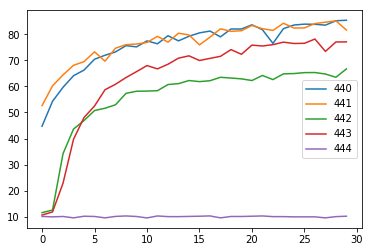

In [21]:
import ast

df = pd.read_csv("mixed-tasks_3-17-134-253/440_iter0.csv")
l = ast.literal_eval(df["task_3"][0])
plt.plot(l, label='440')
df = pd.read_csv("mixed-tasks_3-17-134-253/441_iter0.csv")
l = ast.literal_eval(df["task_3"][0])
plt.plot(l, label='441')
df = pd.read_csv("mixed-tasks_3-17-134-253/442_iter0.csv")
l = ast.literal_eval(df["task_3"][0])
plt.plot(l, label='442')
df = pd.read_csv("mixed-tasks_3-17-134-253/443_iter0.csv")
l = ast.literal_eval(df["task_3"][0])
plt.plot(l, label='443')
df = pd.read_csv("mixed-tasks_3-17-134-253/444_iter0.csv")
l = ast.literal_eval(df["task_3"][0])
plt.plot(l, label='444')
plt.legend()
plt.show()

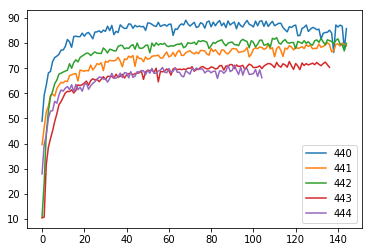

In [80]:
#440 Data
data = pd.read_csv("mixed-tasks_3-17-134-253/440_iter1.csv")
plt.plot(data["task_3"], label="440")
data = pd.read_csv("mixed-tasks_3-17-134-253/441_iter1.csv")
plt.plot(data["task_3"], label="441")
data = pd.read_csv("mixed-tasks_3-17-134-253/442_iter1.csv")
plt.plot(data["task_3"], label="442")
data = pd.read_csv("mixed-tasks_3-17-134-253/443_iter1.csv")
plt.plot(data["task_3"], label="443")
data = pd.read_csv("mixed-tasks_3-17-134-253/444_iter1.csv")
plt.plot(data["task_3"], label="444")
plt.legend()
plt.show()

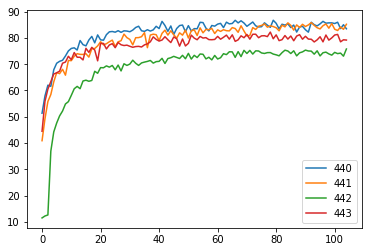

In [81]:
data = pd.read_csv("mixed-tasks_3-17-134-253/440_iter2.csv")
plt.plot(data["task_3"], label="440")
data = pd.read_csv("mixed-tasks_3-17-134-253/441_iter2.csv")
plt.plot(data["task_3"], label="441")
data = pd.read_csv("mixed-tasks_3-17-134-253/442_iter2.csv")
plt.plot(data["task_3"], label="442")
data = pd.read_csv("mixed-tasks_3-17-134-253/443_iter2.csv")
plt.plot(data["task_3"], label="443")
"""
data = pd.read_csv("mixed-tasks_3-17-134-253/444_iter1.csv")
plt.plot(data["task_3"], label="444")
"""
plt.legend()
plt.show()

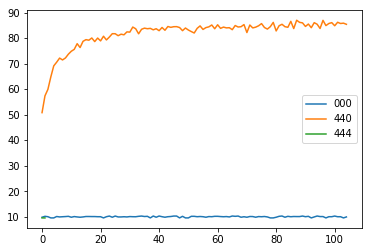

In [91]:
data = pd.read_csv("mixed-tasks_52-15-53-220/000_iter11.csv")
plt.plot(data["task_3"], label="000")
data = pd.read_csv("mixed-tasks_52-15-53-220/440_iter11.csv")
plt.plot(data["task_3"], label="440")
"""
data = pd.read_csv("mixed-tasks_52-15-53-220/441_iter11.csv")
plt.plot(data["task_3"], label="441")
data = pd.read_csv("mixed-tasks_52-15-53-220/442_iter11.csv")
plt.plot(data["task_3"], label="442")
data = pd.read_csv("mixed-tasks_52-15-53-220/443_iter11.csv")
plt.plot(data["task_3"], label="443")
"""
data = pd.read_csv("mixed-tasks_52-15-53-220/444_iter11.csv")
plt.plot(data["task_3"], label="444")
#plt.errorbar([i for i in range(105)], data["task_3"], 3, 3)
plt.legend()
plt.show()

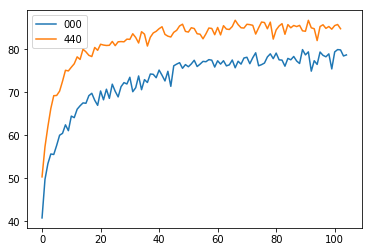

In [89]:
data = pd.read_csv("mixed-tasks_18-217-11-112/000_iter10.csv")
plt.plot(data["task_3"], label="000")
data = pd.read_csv("mixed-tasks_18-217-11-112/440_iter10.csv")
plt.plot(data["task_3"], label="440")
"""
data = pd.read_csv("mixed-tasks_18-217-11-112/441_iter10.csv")
plt.plot(data["task_3"], label="441")
data = pd.read_csv("mixed-tasks_18-217-11-112/442_iter10.csv")
plt.plot(data["task_3"], label="442")
data = pd.read_csv("mixed-tasks_18-217-11-112/443_iter10.csv")
plt.plot(data["task_3"], label="443")
data = pd.read_csv("mixed-tasks_18-217-11-112/444_iter10.csv")
plt.plot(data["task_3"], label="444")
"""
plt.legend()
plt.show()

# Retries Needed

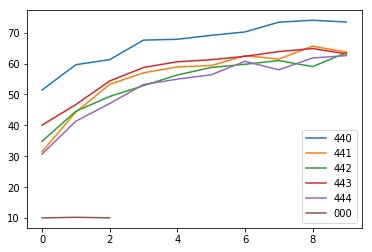

In [35]:
data = pd.read_csv("mixed-tasks_52-15-53-220/440_iter3.csv")
plt.plot(data["task_3"], label="440")
data = pd.read_csv("mixed-tasks_52-15-53-220/441_iter3.csv")
plt.plot(data["task_3"], label="441")
data = pd.read_csv("mixed-tasks_52-15-53-220/442_iter3.csv")
plt.plot(data["task_3"], label="442")
data = pd.read_csv("mixed-tasks_52-15-53-220/443_iter3.csv")
plt.plot(data["task_3"], label="443")
data = pd.read_csv("mixed-tasks_52-15-53-220/444_iter3.csv")
plt.plot(data["task_3"], label="444")
data = pd.read_csv("mixed-tasks_52-15-53-220/000_iter3.csv")
plt.plot(data["task_3"], label="000")
plt.legend()
plt.show()

In [46]:
d = torch.load("mixed-tasks_52-15-53-220/meta000_iter3", map_location='cpu')
print("000 retries needed: ", d["retries"])

d = torch.load("mixed-tasks_52-15-53-220/meta440_iter3", map_location='cpu')
print("440 retries needed: ", d["retries"])

d = torch.load("mixed-tasks_52-15-53-220/meta441_iter3", map_location='cpu')
print("441 retries needed: ", d["retries"])

d = torch.load("mixed-tasks_52-15-53-220/meta442_iter3", map_location='cpu')
print("442 retries needed: ", d["retries"])

d = torch.load("mixed-tasks_52-15-53-220/meta443_iter3", map_location='cpu')
print("443 retries needed: ", d["retries"])

d = torch.load("mixed-tasks_52-15-53-220/meta444_iter3", map_location='cpu')
print("444 retries needed: ", d["retries"])

000 retries needed:  10
440 retries needed:  7
441 retries needed:  0
442 retries needed:  0
443 retries needed:  2
444 retries needed:  0


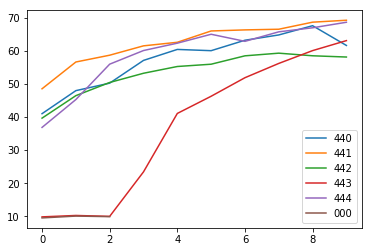

In [49]:
data = pd.read_csv("mixed-tasks_18-217-11-112/440_iter6.csv")
plt.plot(data["task_3"], label="440")
data = pd.read_csv("mixed-tasks_18-217-11-112/441_iter6.csv")
plt.plot(data["task_3"], label="441")
data = pd.read_csv("mixed-tasks_18-217-11-112/442_iter6.csv")
plt.plot(data["task_3"], label="442")
data = pd.read_csv("mixed-tasks_18-217-11-112/443_iter6.csv")
plt.plot(data["task_3"], label="443")
data = pd.read_csv("mixed-tasks_18-217-11-112/444_iter6.csv")
plt.plot(data["task_3"], label="444")
data = pd.read_csv("mixed-tasks_18-217-11-112/000_iter6.csv")
plt.plot(data["task_3"], label="000")
plt.legend()
plt.show()

In [79]:
d = torch.load("mixed-tasks_18-217-11-112/meta000_iter6", map_location='cpu')
print("000 retries needed: ", d["retries"])

d = torch.load("mixed-tasks_18-217-11-112/meta440_iter6", map_location='cpu')
print("440 retries needed: ", d["retries"])

d = torch.load("mixed-tasks_18-217-11-112/meta441_iter6", map_location='cpu')
print("441 retries needed: ", d["retries"])

d = torch.load("mixed-tasks_18-217-11-112/meta442_iter6", map_location='cpu')
print("442 retries needed: ", d["retries"])

d = torch.load("mixed-tasks_18-217-11-112/meta443_iter6", map_location='cpu')
print("443 retries needed: ", d["retries"])

d = torch.load("mixed-tasks_18-217-11-112/meta444_iter6", map_location='cpu')
print("444 retries needed: ", d["retries"])

000 retries needed:  10
440 retries needed:  7
441 retries needed:  0
442 retries needed:  3
443 retries needed:  0
444 retries needed:  10
